In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('data/breast-cancer-diagnostic.shuf.lrn.csv')
df.set_index('ID', inplace=True)
df

,class,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,symmetryMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
ID,,,,,,,,,,,,,,,,,,,,,
8611161,False,13.34,15.86,86.49,520.0,0.10780,0.15350,0.116900,0.069870,0.1942,...,15.53,23.19,96.66,614.9,0.1536,0.47910,0.48580,0.17080,0.3527,0.10160
8912280,True,16.24,18.77,108.80,805.1,0.10660,0.18020,0.194800,0.090520,0.1876,...,18.55,25.09,126.90,1031.0,0.1365,0.47060,0.50260,0.17320,0.2770,0.10630
901303,False,16.17,16.07,106.30,788.5,0.09880,0.14380,0.066510,0.053970,0.1990,...,16.97,19.14,113.10,861.5,0.1235,0.25500,0.21140,0.12510,0.3153,0.08960
86973701,False,14.95,18.77,97.84,689.5,0.08138,0.11670,0.090500,0.035620,0.1744,...,16.25,25.47,107.10,809.7,0.0997,0.25210,0.25000,0.08405,0.2852,0.09218
8511133,True,15.34,14.26,102.50,704.4,0.10730,0.21350,0.207700,0.097560,0.2521,...,18.07,19.08,125.10,980.9,0.1390,0.59540,0.63050,0.23930,0.4667,0.09946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8612399,True,18.46,18.52,121.10,1075.0,0.09874,0.10530,0.133500,0.087950,0.2132,...,22.93,27.68,152.20,1603.0,0.1398,0.20890,0.31570,0.16420,0.3695,0.08579
88147202,False,12.62,23.97,81.35,496.4,0.07903,0.07529,0.054380,0.020360,0.1514,...,14.20,31.31,90.67,624.0,0.1227,0.34540,0.39110,0.11800,0.2826,0.09585
897374,False,12.30,19.02,77.88,464.4,0.08313,0.04202,0.007756,0.008535,0.1539,...,13.35,28.46,84.53,544.3,0.1222,0.09052,0.03619,0.03983,0.2554,0.07207


# First thoughts

The breast cancer data set seems to have 285 instances and 30 features which already tells us that there is a high number of features for a small amount of data with a binary target. We first need to check if there are variables that have high correlation with each other in order to remove some of these highly correlated variables to reduce noise.

In [3]:
# checking for missing values
df.isna().any() #no missing values

class                      False
radiusMean                 False
 textureMean               False
 perimeterMean             False
 areaMean                  False
 smoothnessMean            False
 compactnessMean           False
 concavityMean             False
 concavePointsMean         False
 symmetryMean              False
 fractalDimensionMean      False
 radiusStdErr              False
 textureStdErr             False
 perimeterStdErr           False
 areaStdErr                False
 smoothnessStdErr          False
 compactnessStdErr         False
 concavityStdErr           False
 concavePointsStdErr       False
 symmetryStdErr            False
 fractalDimensionStdErr    False
 radiusWorst               False
 textureWorst              False
 perimeterWorst            False
 areaWorst                 False
 smoothnessWorst           False
 compactnessWorst          False
 concavityWorst            False
 concavePointsWorst        False
 symmetryWorst             False
 fractalDi

# Correlations

The heatmap shows some extremely highly correlated variables. Since the number of features is so high it would probably be best to drop some of the highly correlated columns. Different threshholds could be considered but for 0.8 gives us 17 columns less which is alreadu better than 30 predictors.

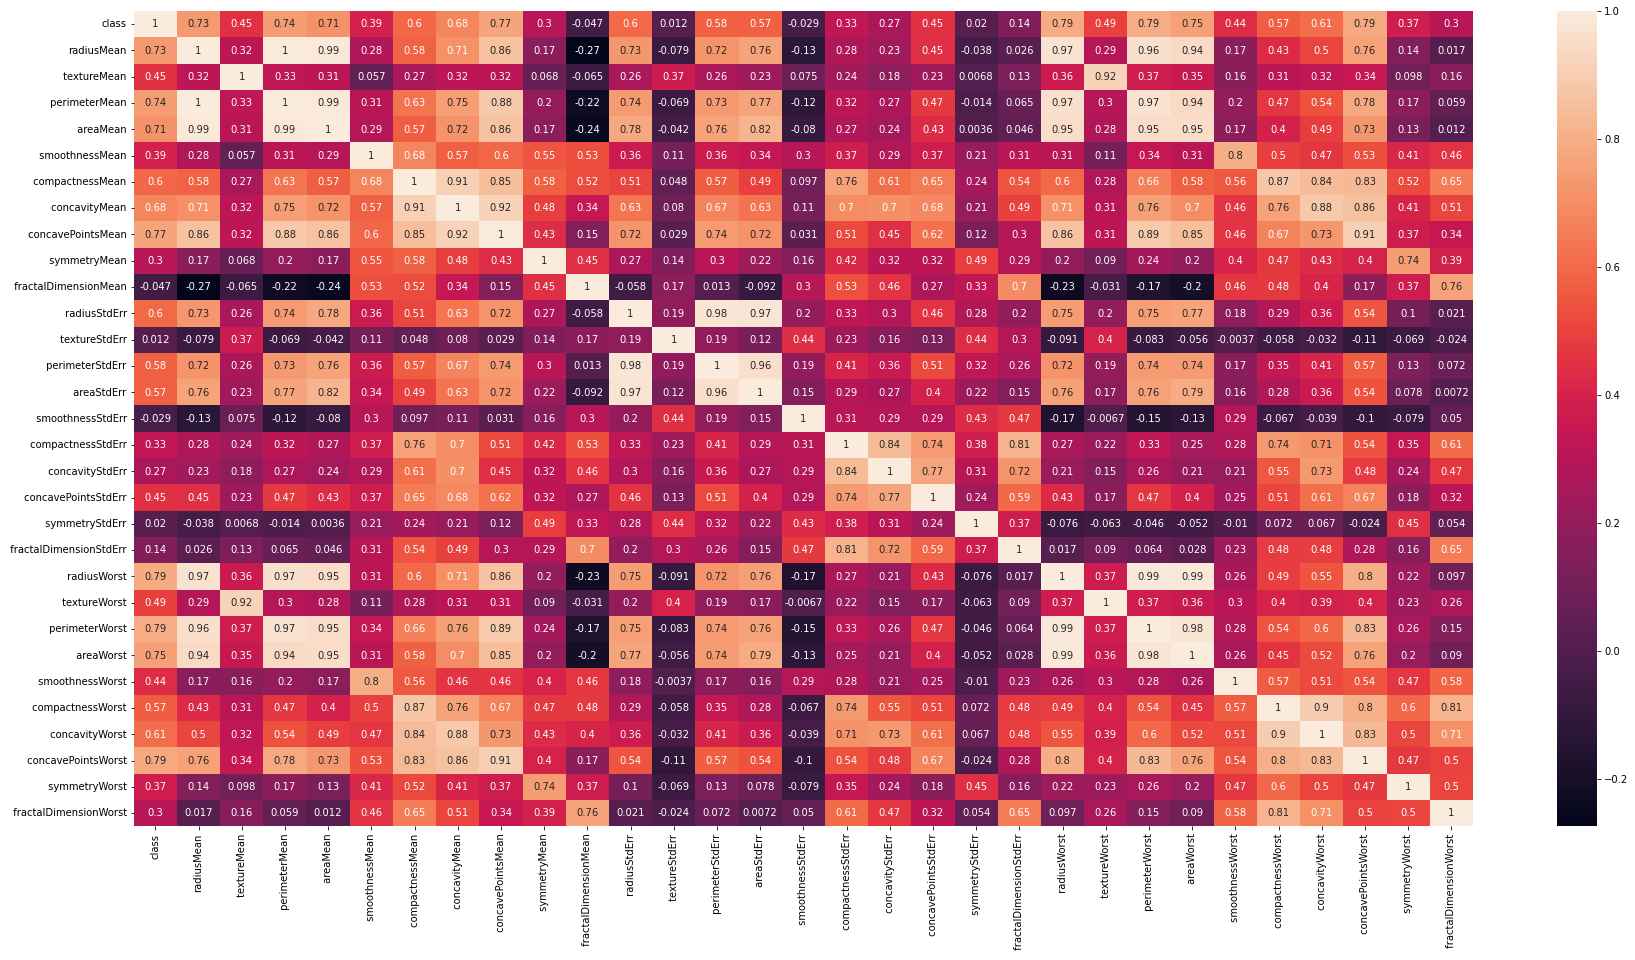

In [4]:
fig, ax = plt.subplots(figsize=(30,15)) 
sns.heatmap(df.corr(), annot=True)
plt.savefig('heatmap.jpg', dpi=300, bbox_inches='tight')

In [5]:
cor_matrix = df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]

class HighCorrRemover(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, to_drop=to_drop):
        X = X.drop(to_drop, axis=1)
        return X

corr_remove = HighCorrRemover()
df_lowCorr = corr_remove.fit_transform(df)
df_lowCorr.shape    


(285, 14)

# Outliers

Our dataset already has a limited amount of data so dropping any more instances is probably not a good idea. However it is still important to maybe perform a boxplot for our data and see possible outliers. The fact that the boxplot might show some variables as outliers doesn't necessarily mean that a value must be an outlier. Domain knowledge is something that could help us give a definite answer on this issue, but we do not posess such knowledge

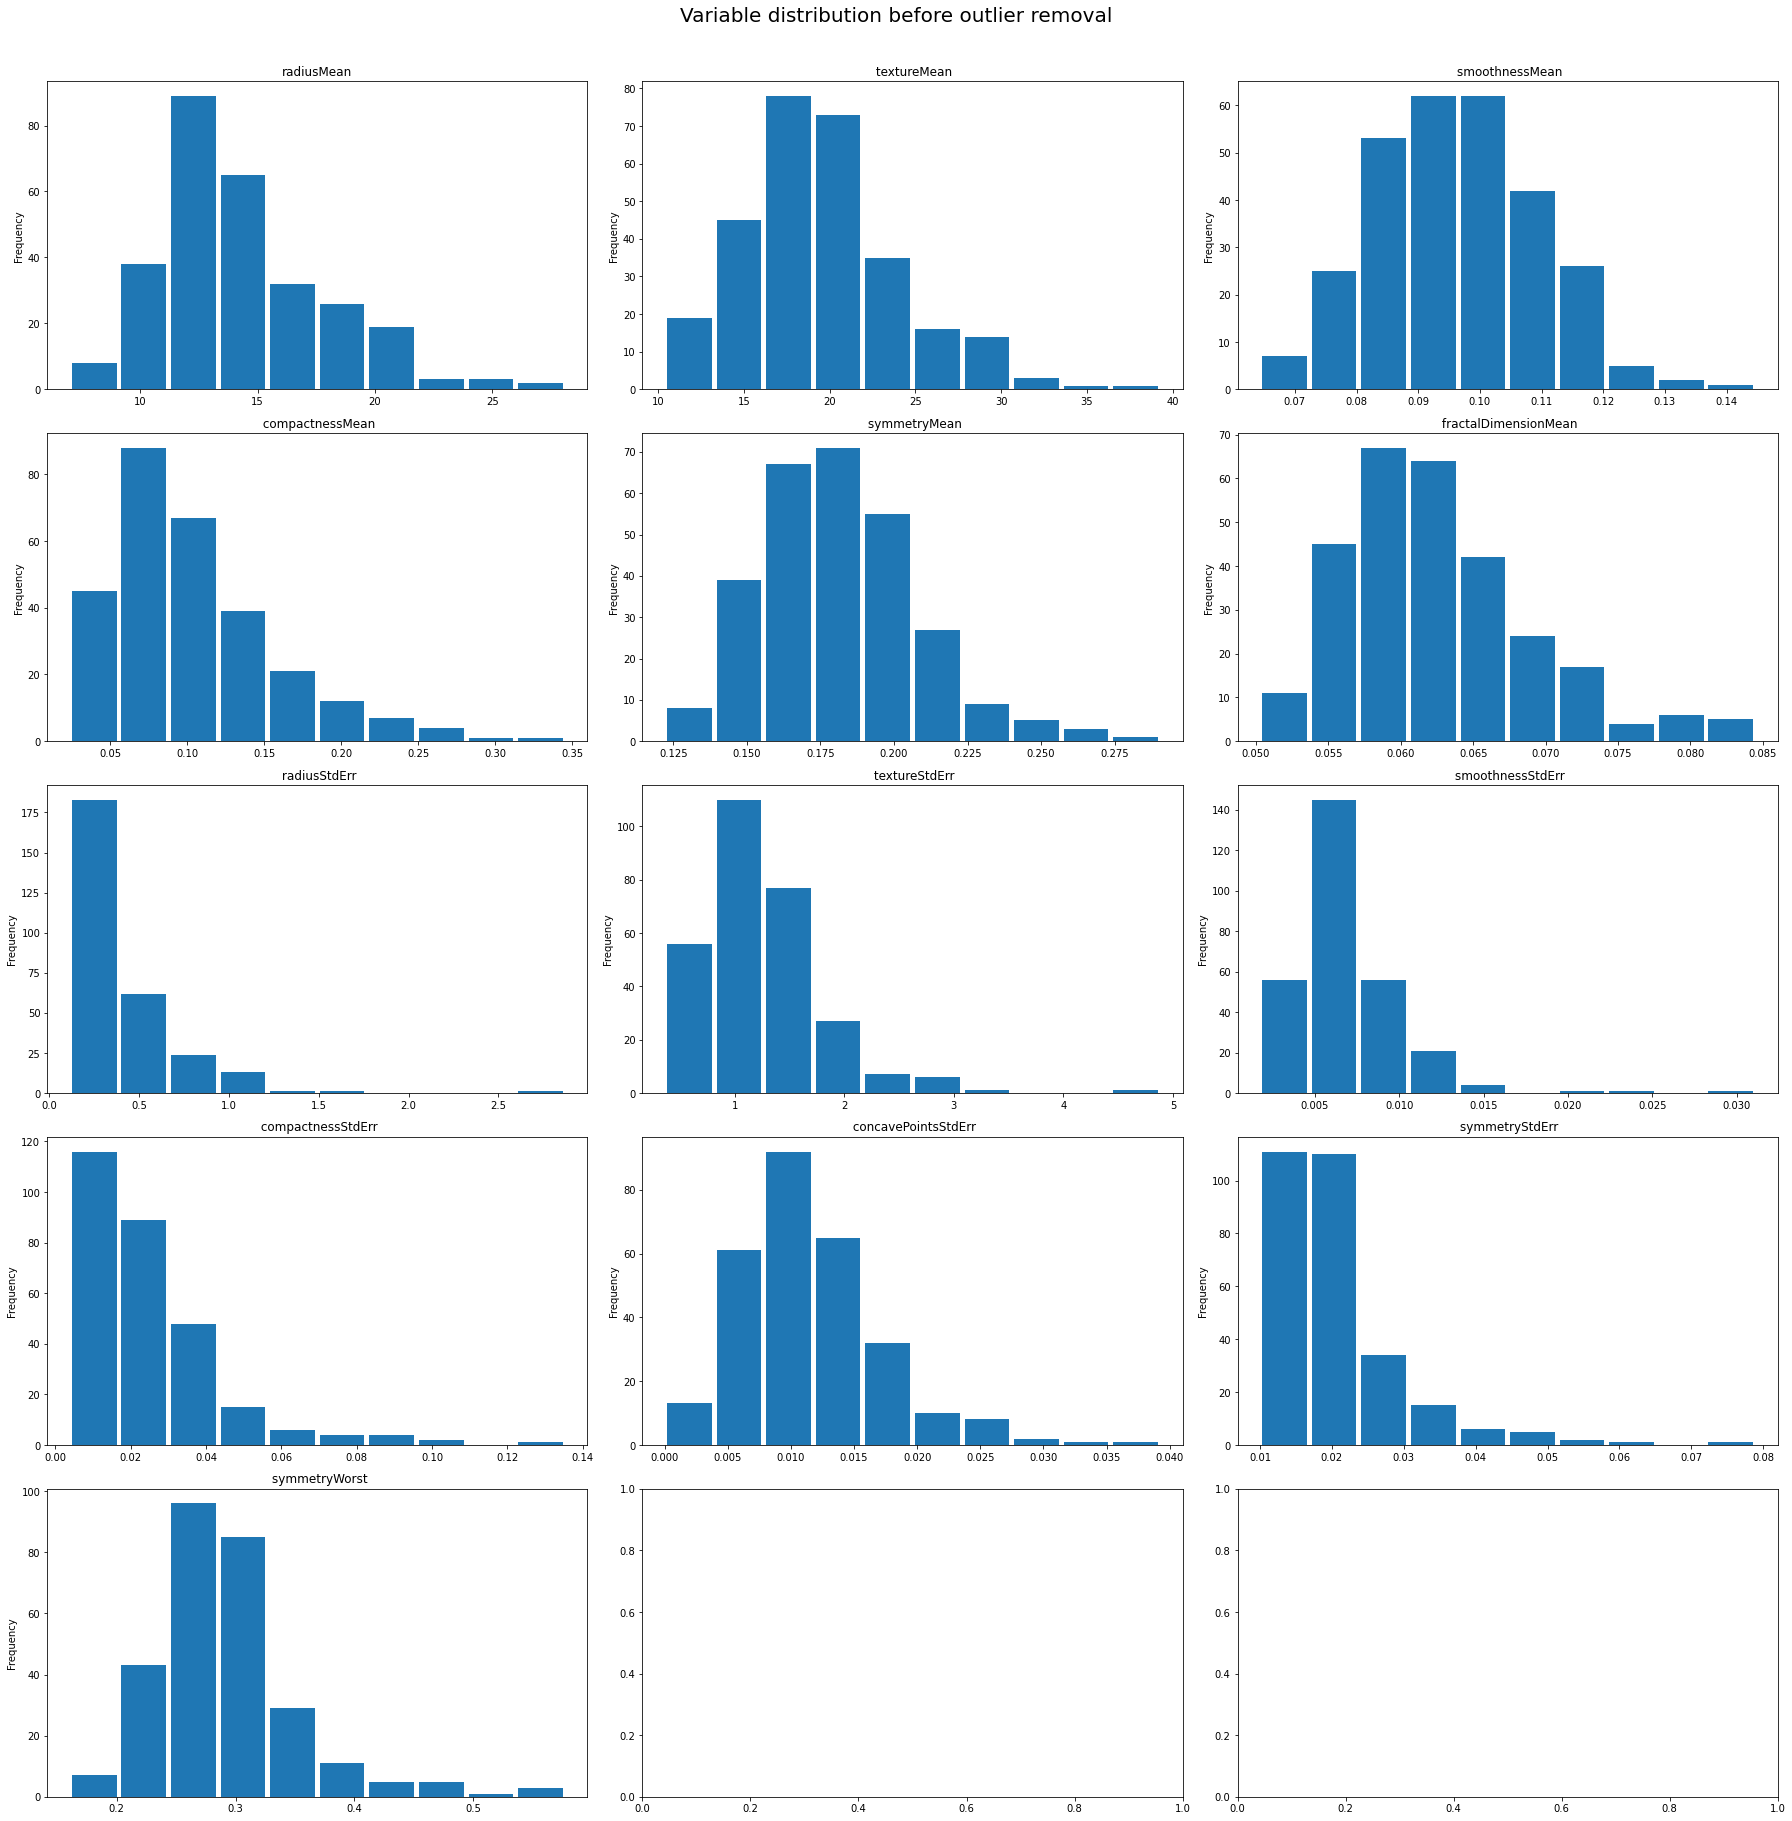

In [6]:
fig, axs = plt.subplots(ncols=3, nrows=5 , figsize= (25,25))
fig.suptitle('Variable distribution before outlier removal', y=1.01, fontsize=20)
for col, ax in zip(df_lowCorr.iloc[: , 1:], axs.ravel()):
    df_lowCorr[col].plot(kind='hist', ax=ax, title=col, rwidth=0.9)

plt.tight_layout()

In [7]:
columns = list(df_lowCorr.loc[:, df_lowCorr.columns != 'class'].columns)
IF = IsolationForest(random_state=42)
IF.fit(df_lowCorr[columns])
df_lowCorr['anomaly'] = IF.predict(df_lowCorr[columns])
len(df_lowCorr[df_lowCorr['anomaly'] == -1])

22

In [8]:
df_lowCorr = df_lowCorr[df_lowCorr.anomaly != -1]
df_lowCorr.shape

(263, 15)

# After Outlier removal

The Isolation Forest model found 22 anomalies in our data set and already with their removal our distributions are looking much better. However some variables are still skewed. We might consider log-transforming some of this skewed variables.

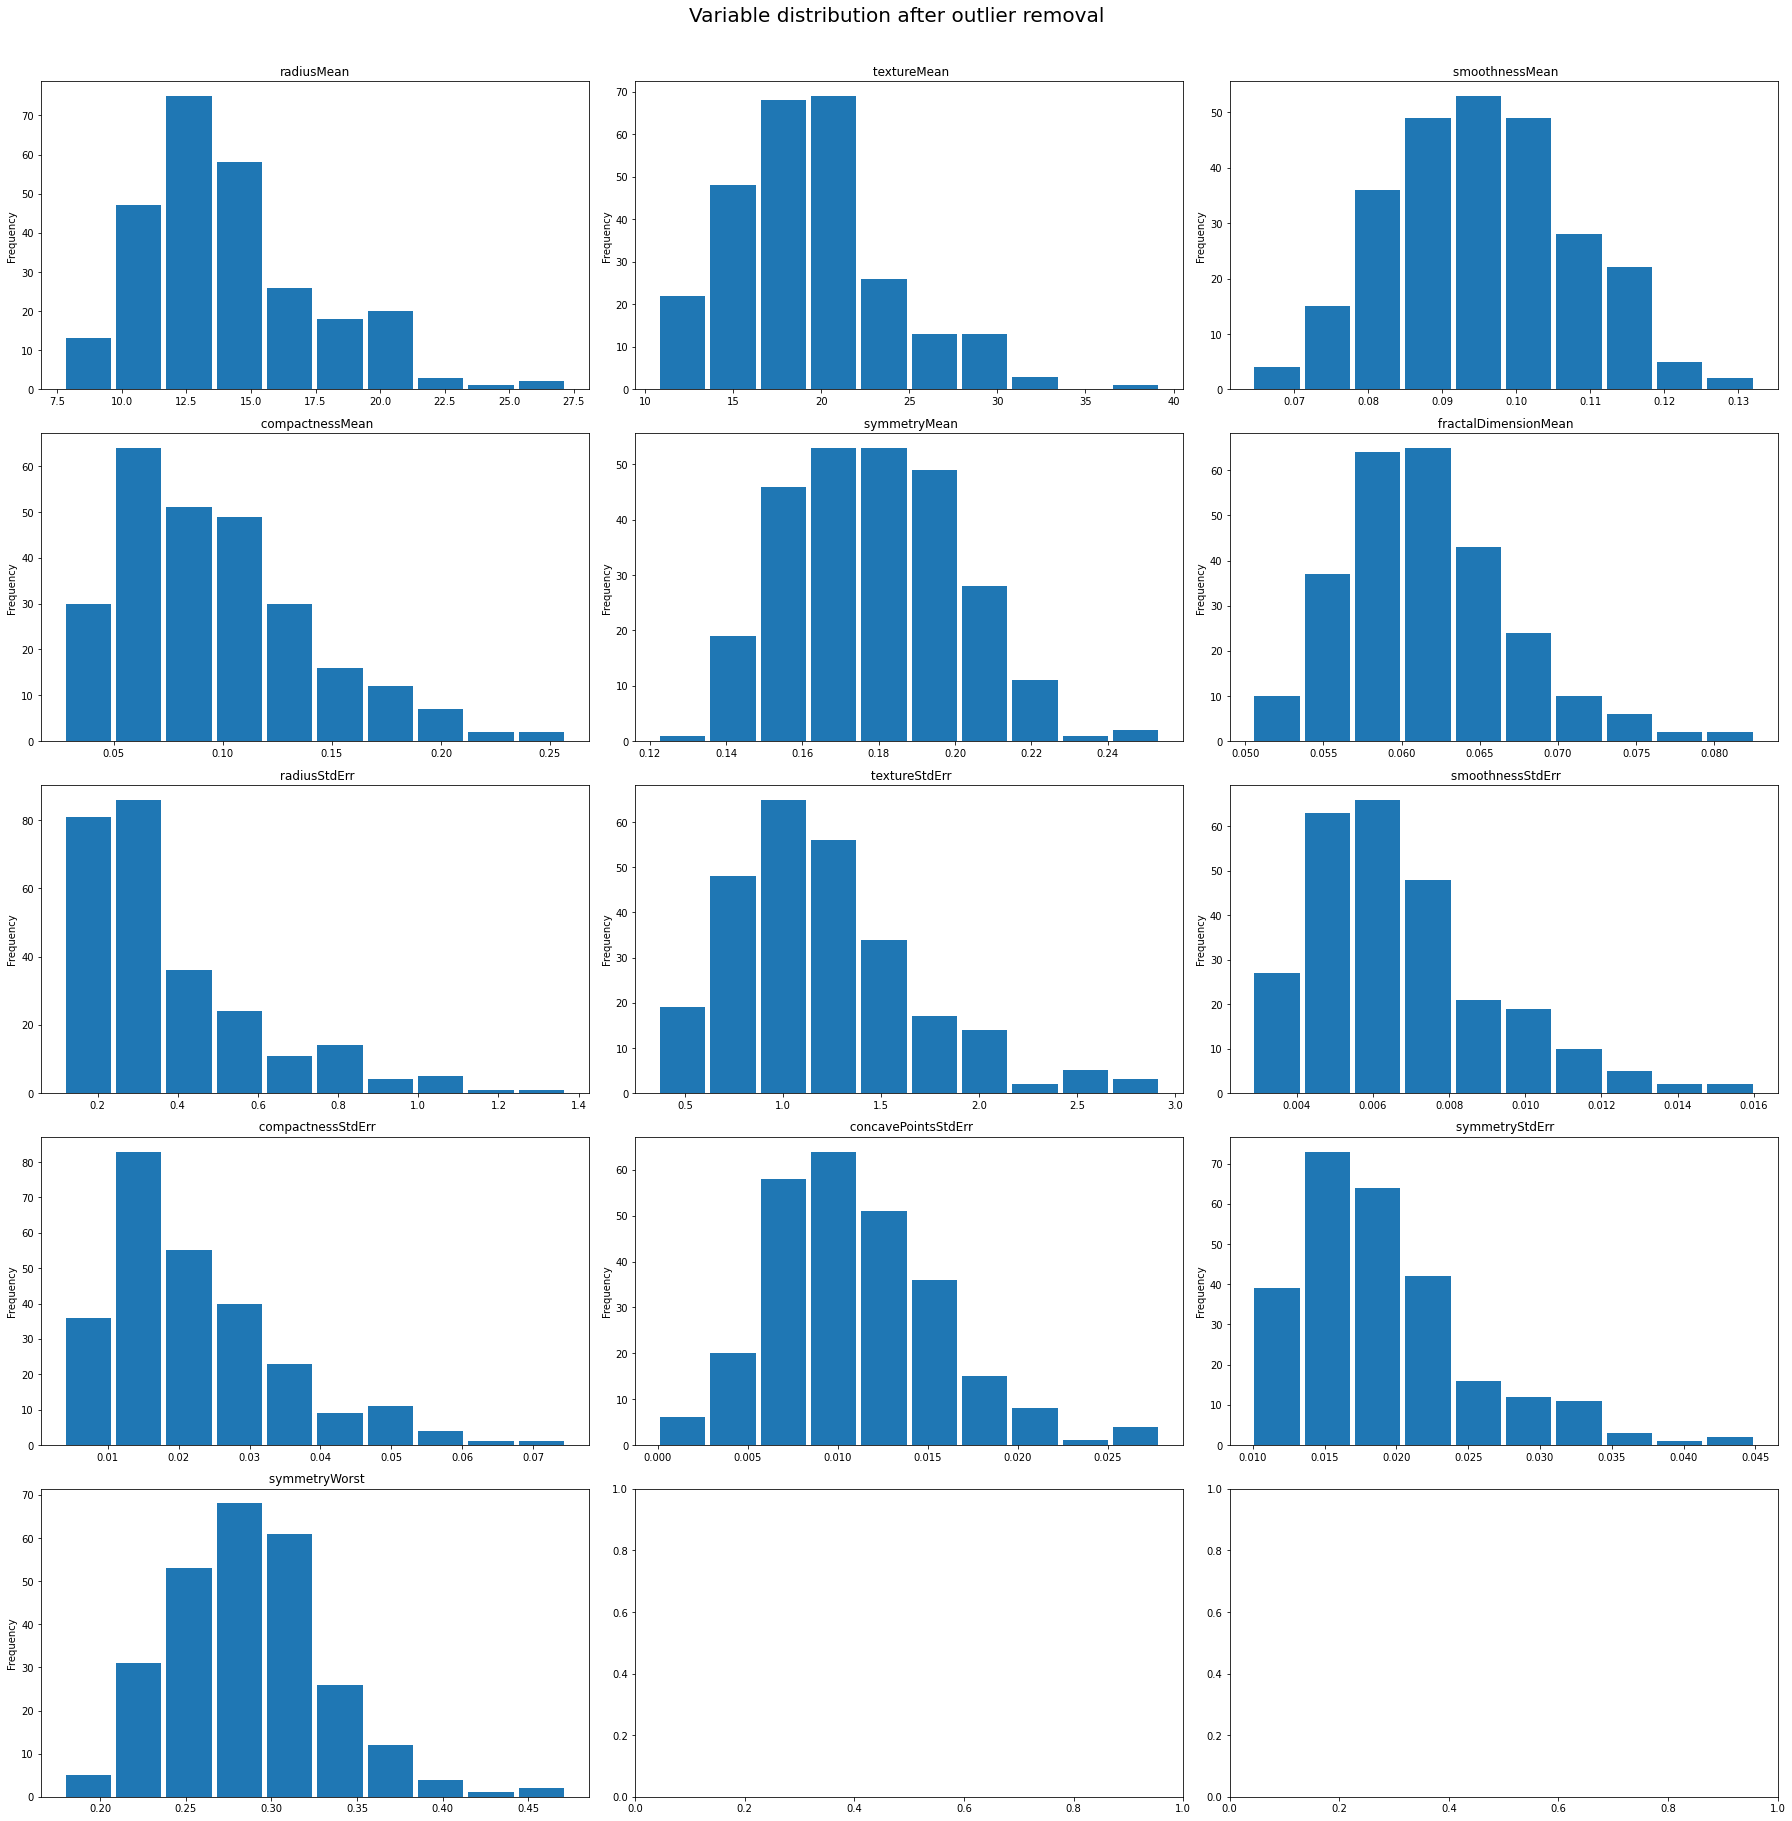

In [9]:
fig, axs = plt.subplots(ncols=3, nrows=5 , figsize= (25,25))
fig.suptitle('Variable distribution after outlier removal', y=1.01, fontsize=20)
for col, ax in zip(df_lowCorr.iloc[: , 1:14], axs.ravel()):
    df_lowCorr[col].plot(kind='hist', ax=ax, title=col, rwidth=0.9)

plt.tight_layout()

In [10]:
class LogTransformer (BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
       X.rename(columns=lambda x: x.lstrip(' '), inplace=True)     
       cols_to_log = ['radiusMean', 'textureMean', 'compactnessMean', 
       'radiusStdErr', 'textureStdErr', 'smoothnessStdErr', 'compactnessStdErr'
       , 'symmetryStdErr', 'fractalDimensionMean']
       X[cols_to_log] = np.log(X[cols_to_log])
       return X

log_trans = LogTransformer()
df_lowCorr_transformed = log_trans.fit_transform(df_lowCorr)


# After Log Transforming

After doing the log transform of the data we can see that the data already looks closer to a normal distribution.

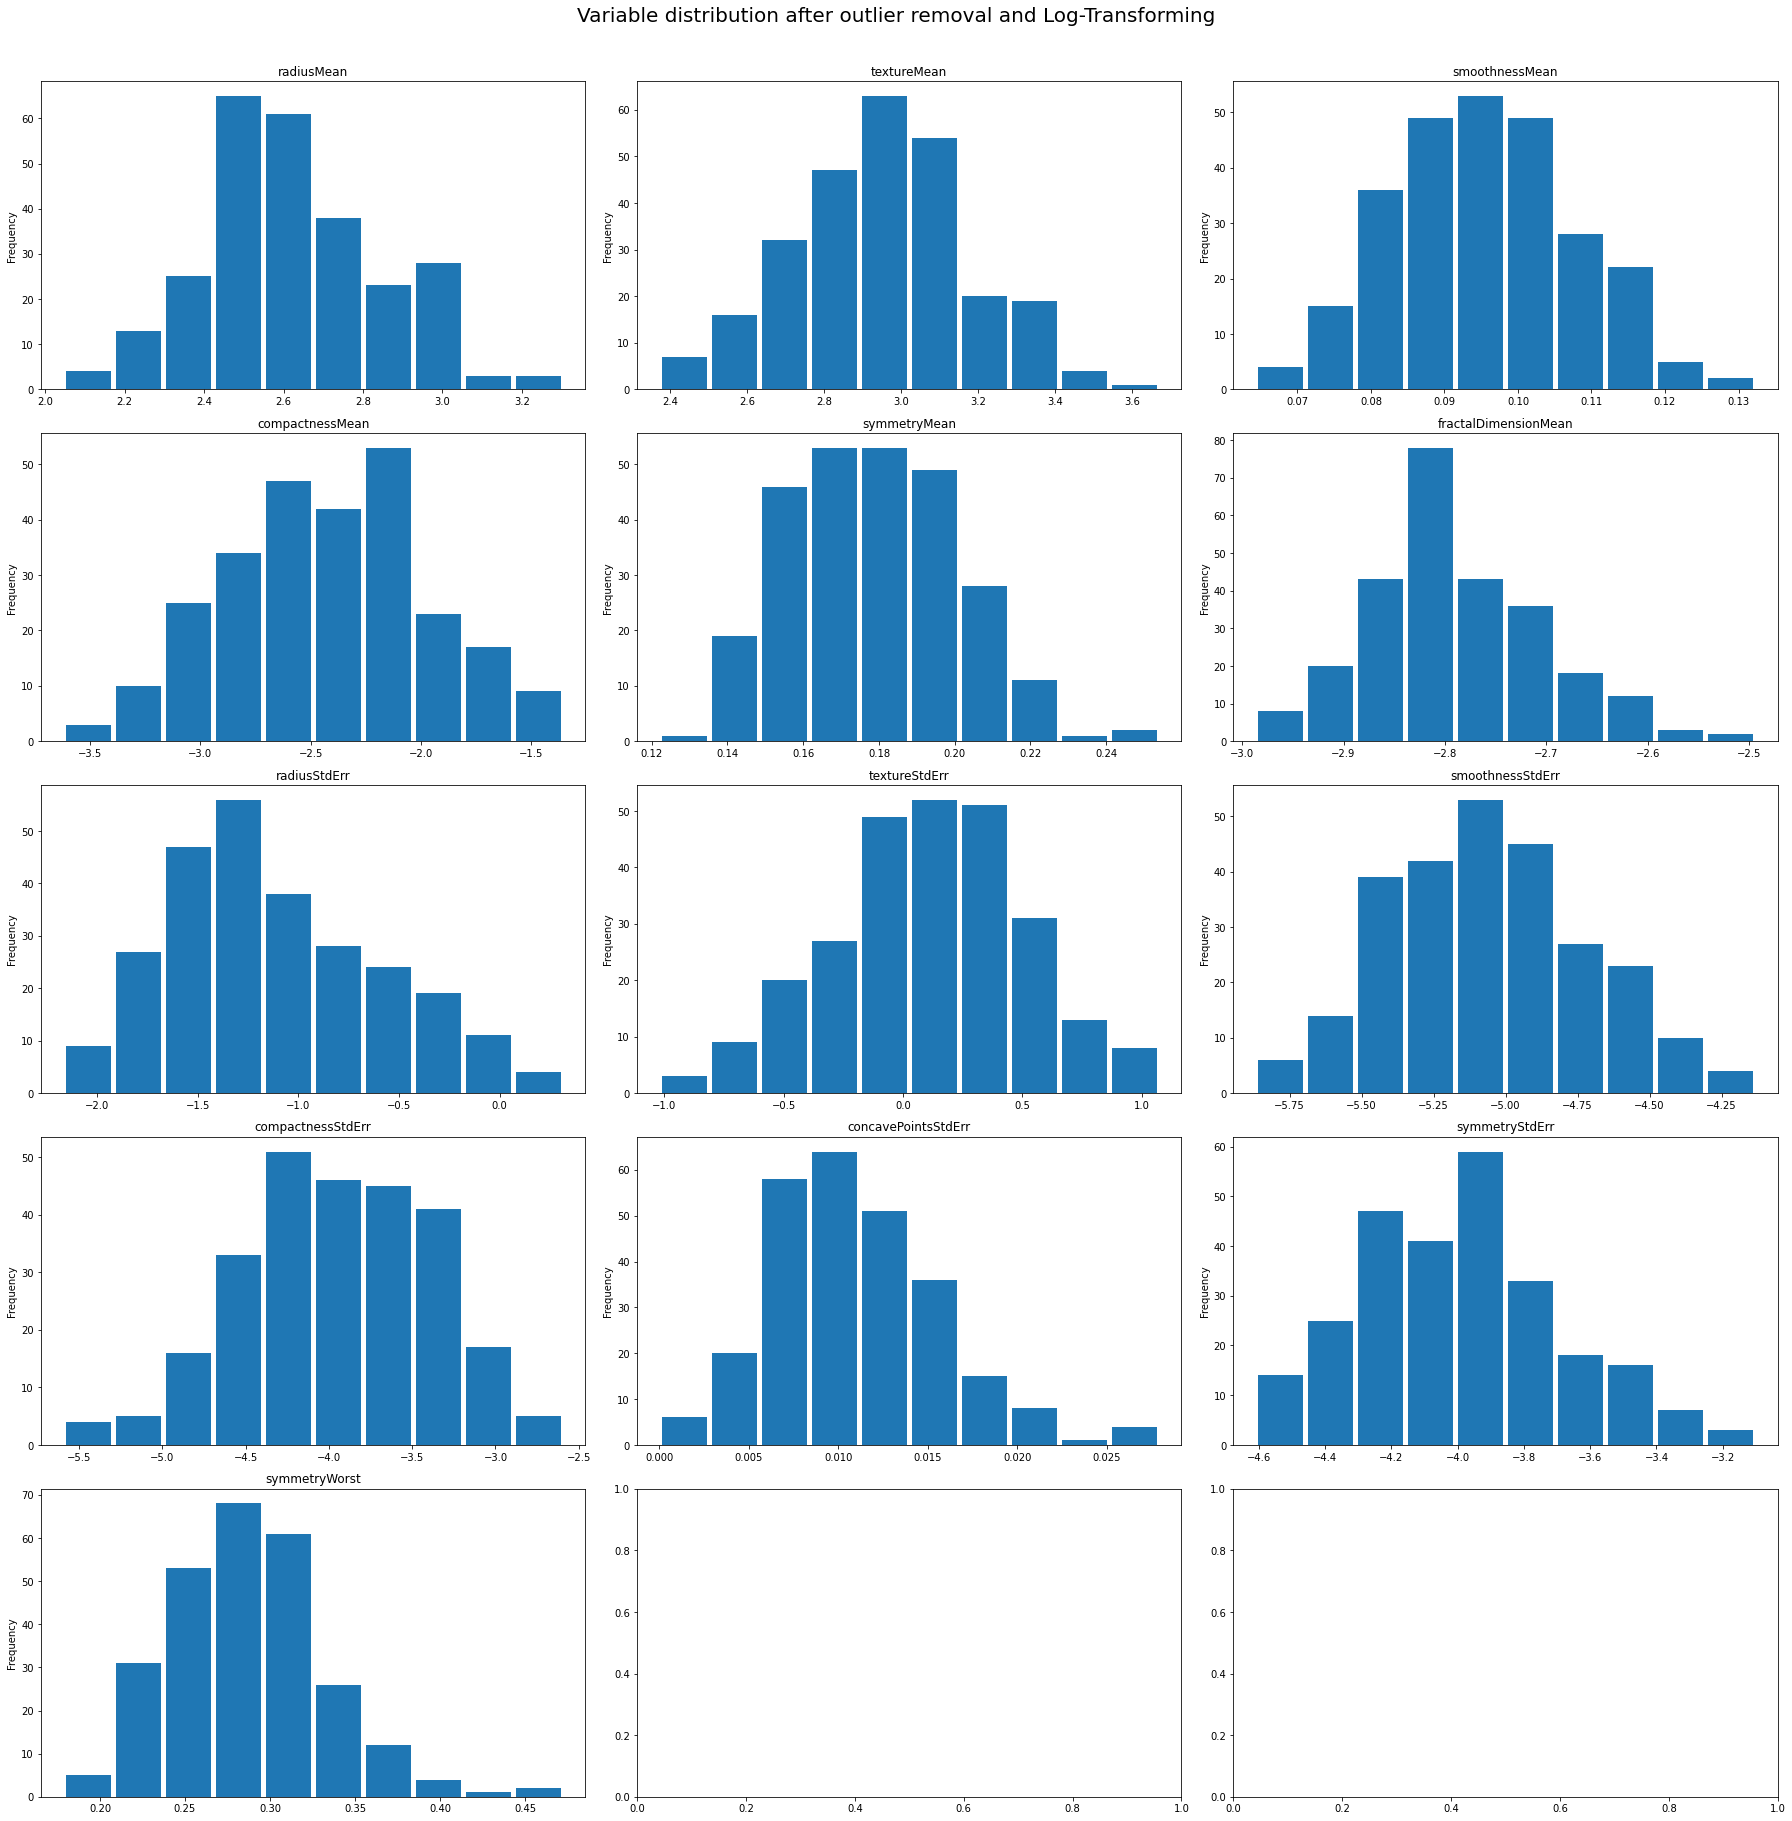

In [11]:
fig, axs = plt.subplots(ncols=3, nrows=5 , figsize= (25,25))
fig.suptitle('Variable distribution after outlier removal and Log-Transforming', y=1.01, fontsize=20)
for col, ax in zip(df_lowCorr_transformed.iloc[: , 1:14], axs.ravel()):
    df_lowCorr_transformed[col].plot(kind='hist', ax=ax, title=col, rwidth=0.9)

plt.tight_layout()
plt.savefig('Variable distribution after outlier removal and Log-Transforming.jpg', dpi=300, bbox_inches='tight')

# Model Selection

First model we're interested to try is the SVM. 

Reference for prediction ( authors found that Support Vector Machine (SVM) was more suitable than the other algorithms and it provided 97.9% accuracy *(N. Fatima, L. Liu, S. Hong and H. Ahmed, "Prediction of Breast Cancer, Comparative Review of Machine Learning Techniques, and Their Analysis," in IEEE Access, vol. 8, pp. 150360-150376, 2020, doi: 10.1109/ACCESS.2020.3016715.)*)

In [12]:
X_transformed = df_lowCorr_transformed.iloc[:, 1:].reset_index()
y_transformed = df_lowCorr_transformed.reset_index()['class'].to_numpy()

X = df_lowCorr.iloc[:, 1:].reset_index()
y = df_lowCorr.reset_index()['class'].to_numpy()

X_train_trans, X_test_trans, y_train_trans, y_test_trans = train_test_split(X_transformed, y_transformed, test_size = 0.2, random_state = 101, stratify=y_transformed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101, stratify=y)

In [13]:
svc_model_trans = SVC()
svc_model_trans.fit(X_train_trans, y_train_trans)
svc_predict_trans = svc_model_trans.predict(X_test_trans)
pd.DataFrame(classification_report(y_test_trans, svc_predict_trans, output_dict=True)).T

,precision,recall,f1-score,support
False,0.702128,0.970588,0.814815,34.000000
True,0.833333,0.263158,0.400000,19.000000
accuracy,0.716981,0.716981,0.716981,0.716981
macro avg,0.767730,0.616873,0.607407,53.000000
weighted avg,0.749164,0.716981,0.666108,53.000000


# Conclusion on Transforming

After training two base models on transformed and non transformed data, we see that there is no difference between theese models so we can spare the transforming of the data.

In [14]:
svc_model = SVC()
svc_model.fit(X_train, y_train)
svc_predict = svc_model.predict(X_test)
pd.DataFrame(classification_report(y_test, svc_predict, output_dict=True)).T

,precision,recall,f1-score,support
False,0.702128,0.970588,0.814815,34.000000
True,0.833333,0.263158,0.400000,19.000000
accuracy,0.716981,0.716981,0.716981,0.716981
macro avg,0.767730,0.616873,0.607407,53.000000
weighted avg,0.749164,0.716981,0.666108,53.000000


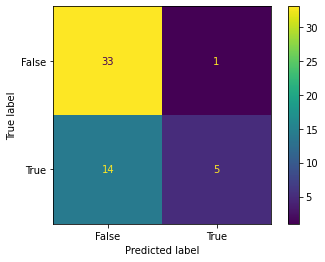

In [15]:
cm = confusion_matrix(y_test, svc_predict, labels=svc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_model.classes_)
disp.plot()

# Base Model performance

Base model performance yields 71.7% accuracy, but low F1 scores and ROC AUC score. This should be improved with hyperparameter tuning

In [16]:
print("Accuracy (SVM):", accuracy_score(y_test, svc_predict))
print("F1 Score (SVM):", f1_score(y_test, svc_predict))
print("ROC AUC Score (SVM):", roc_auc_score(y_test, svc_predict))

Accuracy (SVM): 0.7169811320754716
F1 Score (SVM): 0.39999999999999997
ROC AUC Score (SVM): 0.6168730650154799


# Using other Classifiers

We will perform the same base model training and prediction with two more classifiers. Other State of The Art algorithms we could use include Random Forest and K-NN *(Y. Khourdifi and M. Bahaj, "Applying Best Machine Learning Algorithms for Breast Cancer Prediction and Classification," 2018 International Conference on Electronics, Control, Optimization and Computer Science (ICECOCS), 2018, pp. 1-5, doi: 10.1109/ICECOCS.2018.8610632.)*


# Results 

RandomForest is performing surprisingly good without any hyperparameter tuning whereas kNN is so far the worst performing algorithm.

In [17]:
rf_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()

rf_clf.fit(X_train, y_train)
knn_clf.fit(X_train, y_train)

rf_pred = rf_clf.predict(X_test)
knn_pred = knn_clf.predict(X_test)

print("RandomForestClassifier :")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("F1 Score:", f1_score(y_test, rf_pred))
print("ROC AUC Score:", roc_auc_score(y_test, rf_pred))
print(" ")
print("K-Nearest-Neighbors Classifier :")
print("Accuracy:", accuracy_score(y_test, knn_pred))
print("F1 Score:", f1_score(y_test, knn_pred))
print("ROC AUC Score:", roc_auc_score(y_test, knn_pred))

RandomForestClassifier :
Accuracy: 0.9056603773584906
F1 Score: 0.8717948717948718
ROC AUC Score: 0.903250773993808
 
K-Nearest-Neighbors Classifier :
Accuracy: 0.6981132075471698
F1 Score: 0.5294117647058824
ROC AUC Score: 0.6486068111455108


# Improving model performance

So far we ran predictions with the default set of hyperparameters for each model. We will now perform Grid Cearch CV in order to find the best hyperparameters for each model.

## SVM

For SVM we consider the following hyperparameters:

* C: It is the regularization parameter, C, of the error term.
* kernel: It specifies the kernel type to be used in the algorithm. It can be ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’, or callable. The default value is ‘rbf’.
* degree: It is the degree of the polynomial kernel function (‘poly’) and is ignored by all other kernels. The default value is 3.
* gamma: It is the kernel coefficient for ‘rbf’, ‘poly’, and ‘sigmoid’. If gamma is ‘auto’, then 1/n_features will be used instead.

For C and gamma we consider the following value range:

C = [$2^{-5}, 2^{-3},2^{-1},2^{2},2^{4},2^{6},2^{8}$] \
gamma = [$2^{-8}, 2^{-4}, 2^{-2}, 2^{3}$]

Reference: *Hsu, Chih-wei & Chang, Chih-chung & Lin, Chih-Jen. (2003). A Practical Guide to Support Vector Classification Chih-Wei Hsu, Chih-Chung Chang, and Chih-Jen Lin.*


In [ ]:
C_param = [np.float_power(2, -5), np.float_power(2, -3), np.float_power(2, -1), np.power(2, 2), np.power(2, 4), np.power(2,6), np.power(2, 8)]
gamma_param = [np.float_power(2, -8), np.float_power(2, -4), np.float_power(2, -2), 1, np.power(2, 3)]
param_grid_svm = { 'C': C_param,
                'kernel':['rbf','poly','sigmoid','linear'],
                'degree':[1,2,3,4,5,6],
                'gamma': gamma_param}
                
grid_svm = GridSearchCV(SVC(random_state=42), param_grid_svm)
grid_svm.fit(X_train, y_train)

print(grid_svm.best_params_)
print(grid_svm.score(X_test, y_test))

## RandomForest


In [ ]:
param_grid_rf = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid_rf)
grid_rf.fit(X_train, y_train)

print(grid_rf.best_params_)
print(grid_rf.score(X_test, y_test))

## KNN

In [ ]:
param_grid_knn = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn)

grid_knn.fit(X_train, y_train)

print(grid_knn.best_params_)
print(grid_knn.score(X_test, y_test))

## Notes

for prediction ( authors found that Support Vector Machine (SVM) was more suitable than the other algorithms and it provided 97.9% accuracy *(N. Fatima, L. Liu, S. Hong and H. Ahmed, "Prediction of Breast Cancer, Comparative Review of Machine Learning Techniques, and Their Analysis," in IEEE Access, vol. 8, pp. 150360-150376, 2020, doi: 10.1109/ACCESS.2020.3016715.)*)

As an opening it is good to include what our hypothesis is and how are we going to test it. See Experiment Design for Data Science.

For me: Don't forget to mention why there is no need for scaling of features in this case